In [1]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib;
import matplotlib.pyplot as plt

/Users/rein/git/rebound/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


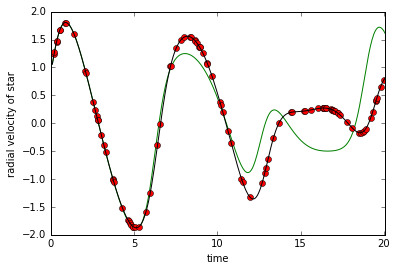

In [10]:
sample_times = np.sort(np.random.rand(100)*20.)
def generatedata(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.move_to_com()
    samples = np.zeros((len(sample_times)))
    for i,t in enumerate(sample_times):
        sim.integrate(t)
        samples[i] = sim.particles[0].vx
    return samples
def generateplotpoints(x,N,interact=1.):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    if interact==0:
        sim.testparticle_type = 1
        sim.N_active = 1    
    sim.move_to_com()
    samples = np.zeros((N))
    times = np.linspace(sample_times[0]-0.1,sample_times[-1]+0.1,N)
    for i,t in enumerate(times):
        sim.integrate(t)
        samples[i] = sim.particles[0].vx
    return times, samples
def generatel(x,interact=1.):
    a, e = x
    sim = rebound.Simulation()
    sim.ri_ias15.min_dt = 0.01
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.Ginteract = interact
    
    sim.move_to_com()
    l = 0.
    for i, t in enumerate(sample_times):
        sim.integrate(t)
        rvobs = samples_true[i]
        rv = sim.particles[0].vx
        l += (rv-rvobs)*(rv-rvobs)
    return l
x_true = (1.0,0.2500)
samples_true = generatedata(x_true)
t,s = generateplotpoints(x_true,400)
t,sni = generateplotpoints(x_true,400,0.)
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_xlabel("time")
ax.set_xlim(0.,np.max(t))
ax.set_ylabel("radial velocity of star")
im = ax.plot(t, 1000.*sni, "r-",color="green")
im = ax.plot(sample_times, 1000.*samples_true, "ro")


im = ax.plot(t, 1000.*s, "r-",color="black")

In [9]:
def H(a,lam):
    x = (a,0.2500)
    return generatel(x,lam)


    

In [4]:
def null(A, eps=1e-15):
    u, s, vh = np.linalg.svd(A)
    null_mask = (s <= eps)
    null_space = np.compress(null_mask, vh, axis=0)
    return np.transpose(null_space)

In [26]:
A = np.array([[2.8,8.3],[0,0,]])  

In [28]:
nv = null(A)[:,0]
print nv
nv = nv / np.linalg.norm(nv)
print nv

[-0.94753551  0.31965053]
[-0.94753551  0.31965053]


In [33]:
def generateldl(x,interact=1.):
    a, e = x
    sim = rebound.Simulation()
    sim.ri_ias15.min_dt = 0.01
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.Ginteract = interact
    var_da = sim.add_variation()
    var_da.init_particle(1,"a")
    
    sim.move_to_com()
    l = 0.
    dl = 0.
    for i, t in enumerate(sample_times):
        sim.integrate(t)
        rvobs = samples_true[i]
        rv = sim.particles[0].vx
        drv = var_da.particles[0].vx
        l += (rv-rvobs)*(rv-rvobs)
        dl += 2.*drv*(rv-rvobs)
    return l, dl



In [ ]:
N=32
grid = np.zeros((N,N))
gridlam = np.linspace(0,1,N)
grida = np.linspace(0.9,1.1,N)
for i, lam in enumerate(gridlam):
    for j, a in enumerate(grida):
        l, ldl = generateldl((a, 0.25),lam)
        grid[j][i] = ldl

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
extent = [min(gridlam),max(gridlam),min(grida),max(grida)]
ax.set_xlim(extent[0],extent[1])
ax.set_ylabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_xlabel("$\lambda$")
im = ax.imshow(grid, vmin=-0.002, vmax=0.002, origin="lower",aspect='auto', extent=extent) #interpolation="none",
cb = plt.colorbar(im, ax=ax)
cb.set_label('$H$')